In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
# Galerkin Basis functions
def phi(x_i,z_i,x_j,z_j,a):
    eps = 1e-6
    r = np.sqrt((x_i-x_j)**2 + (z_i-z_j)**2)
    
    return np.exp(-(a*r)**2)

def nabla2(xi,zi,xj,zj,a):
    eps = 1e-6
    return 4*a**2*(a**2*(xi - xj)**2 + a**2*(zi - zj)**2 - 1)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def dphidx(xi,zi,xj,zj,a):
    return 2*a**2*(-xi + xj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def dphidz(xi,zi,xj,zj,a):
    return 2*a**2*(-zi + zj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def d2phidx2(xi,zi,xj,zj,a):
    return a**2*(4*a**2*(xi - xj)**2 - 2)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def d2phidz2(xi,zi,xj,zj,a):
    return a**2*(4*a**2*(zi - zj)**2 - 2)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))

def d2phidxdz(xi,zi,xj,zj,a):
    return 4*a**4*(xi - xj)*(zi - zj)*np.exp(-a**2*((xi - xj)**2 + (zi - zj)**2))


In [3]:
#numerical parameters
pi = 3.14159
dx = 0.1
a = 1/(5*dx) #fitting parameter for galerkin functions
g = 1.0
tilt_angle = pi/4

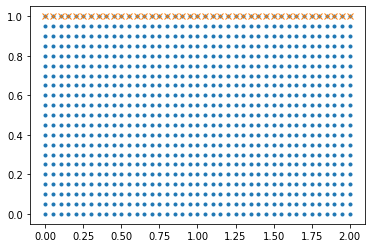

In [4]:
#building grid:
dx = 0.05
xx,zz = np.meshgrid(np.arange(0,2+dx,dx),np.arange(0,1+dx,dx))
xxi = xx[1:-1,1:-1]
zzi = zz[1:-1,1:-1]
nxi = xxi.shape[0]
nzi = zzi.shape[1]
Xinternal = np.stack((xxi.flatten(),zzi.flatten()),axis=1)
Xbc1 = np.stack((xx[1:-1,0].flatten(),zz[1:-1,0].flatten()),axis=1)
Xbc2 = np.stack((xx[1:-1,-1].flatten(),zz[1:-1,-1].flatten()),axis=1)
Xbc3 = np.stack((xx[0,:].flatten(),zz[0,:].flatten()),axis=1)
Xbc4 = np.stack((xx[-1,:].flatten(),zz[-1,:].flatten()),axis=1)
nbc0 = Xinternal.shape[0]
nbc1 = Xbc1.shape[0] + nbc0
nbc2 = Xbc2.shape[0] + nbc1
nbc3 = Xbc3.shape[0] + nbc2 
ncb4 = Xbc4.shape[0] + nbc3
X = np.concatenate((Xinternal,Xbc1,Xbc2,Xbc3,Xbc4),axis=0)
N = X.shape[0]

plt.plot(X[:,0],X[:,1],'.')
plt.plot(Xbc4[:,0],Xbc4[:,1],'x')

In [5]:
#velocity solution:
#Power law solution for K = 1 and n = -1/2

u_test = X[:,1:2]-X[:,1:2]**2 + X[:,1:2]**3/3
v_test = u_test*0

#finding relevent derivative fields:

a = 1/(5*dx)

phi_u = np.zeros((N,N))
nabla2_phi_u = np.zeros((N,N))
dphi_u_dx = np.zeros((N,N))
dphi_u_dz = np.zeros((N,N))
d2phi_u_dx2 = np.zeros((N,N))
d2phi_u_dz2 = np.zeros((N,N))
d2phi_u_dxdz = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        phi_u[i,j] = phi(X[i,0],X[i,1],X[j,0],X[j,1],a)
        nabla2_phi_u[i,j] = nabla2(X[i,0],X[i,1],X[j,0],X[j,1],a)
        dphi_u_dx[i,j] = dphidx(X[i,0],X[i,1],X[j,0],X[j,1],a)
        dphi_u_dz[i,j] = dphidz(X[i,0],X[i,1],X[j,0],X[j,1],a)
        d2phi_u_dx2[i,j]  = d2phidx2(X[i,0],X[i,1],X[j,0],X[j,1],a)
        d2phi_u_dz2[i,j]  = d2phidz2(X[i,0],X[i,1],X[j,0],X[j,1],a)
        d2phi_u_dxdz[i,j]  = d2phidxdz(X[i,0],X[i,1],X[j,0],X[j,1],a)


u_j = np.linalg.solve(phi_u,u_test)
v_j = np.linalg.solve(phi_u,v_test)

u = np.diag(u_test.flatten())
v = np.diag(v_test.flatten())
nabla2_u = np.diag(np.matmul(nabla2_phi_u,u_j).flatten())
nabla2_v = np.diag(np.matmul(nabla2_phi_u,v_j).flatten())
dudx = np.diag(np.matmul(dphi_u_dx,u_j).flatten())
dudz = np.diag(np.matmul(dphi_u_dz,u_j).flatten())
dvdx = np.diag(np.matmul(dphi_u_dx,v_j).flatten())
dvdz = np.diag(np.matmul(dphi_u_dz,v_j).flatten())
d2udx2 = np.diag(np.matmul(d2phi_u_dx2,u_j).flatten())
d2udz2 = np.diag(np.matmul(d2phi_u_dz2,u_j).flatten())
d2udxdz = np.diag(np.matmul(d2phi_u_dxdz,u_j).flatten())
d2vdx2 = np.diag(np.matmul(d2phi_u_dx2,v_j).flatten())
d2vdz2 = np.diag(np.matmul(d2phi_u_dz2,v_j).flatten())
d2vdxdz = np.diag(np.matmul(d2phi_u_dxdz,v_j).flatten())

In [6]:
gov_mat = np.zeros((2*N,2*N))

#horizontal momentum:

#viscosity terms
gov_mat[0:N,0:N] =  d2phi_u_dx2 + d2phi_u_dz2

#pressure term

gov_mat[0:N,N:2*N] = 0

#vertical momentum:

gov_mat[N:2*N,N:2*N] =  d2phi_u_dx2 + d2phi_u_dz2

#pressure term

gov_mat[N:2*N,N:2*N] = 0


#boundary conditions
#at the surface we require that mu = 0 and p = 0

gov_mat[nbc3:N,:] = 0
gov_mat[nbc3+N:2*N,:] = 0
gov_mat[nbc3:N,:] = 0
gov_mat[nbc3+N:2*N,:] = 0

#viscosity bc:
gov_mat[nbc3:N,0:N] = phi_u[nbc3:N,0:N]

#pressure bc:
gov_mat[nbc3+N:2*N,N:2*N] = phi_u[nbc3:N,0:N]



In [7]:
#inhomogeneous condition

bc_vector = np.zeros((2*N,1))
bc_vector[0:N,0] = 0
bc_vector[N:2*N,0] = 0
bc_vector[nbc3:N,0] = 1
bc_vector[nbc3+N:2*N,0] = 1

solution_vector = np.linalg.solve(gov_mat,bc_vector)

p = np.matmul(phi_u,solution_vector[N:2*N,:])
nu = np.matmul(phi_u,solution_vector[0:N,:])

LinAlgError: Singular matrix

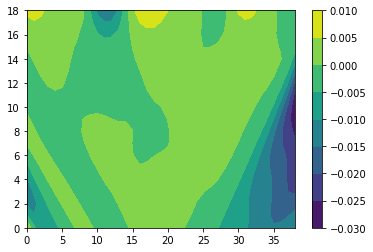

In [ ]:
plt.contourf(nu[0:nbc0,:].reshape((nxi,nzi)))
plt.colorbar() 

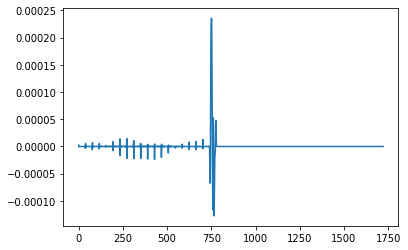

In [ ]:
plt.plot(bc_vector)